In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from spectral import *
import spectral.io.envi as envi

In [2]:
data_ref = envi.open('10a_101012-120551_refl_ss.hdr', '10a_101012-120551_refl_ss.dat')
data = np.array(data_ref.load())
print (data.shape) # wavelength1043-2486 nm in 230 bands

(285, 200, 230)


ImageView object:
  Display bands       :  (0, 200, 220)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.5314581394195557]
    G: [0.0, 0.561603307723999]
    B: [0.0, 0.4880259037017822]

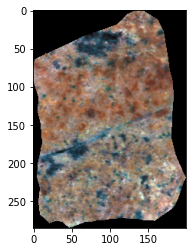

In [3]:
#image can't be displayed as RGB, the image already sliced in the Infrared range.
imshow(data, (0, 200, 220)) #in this case, I randomly select band to check if the image loaded properly

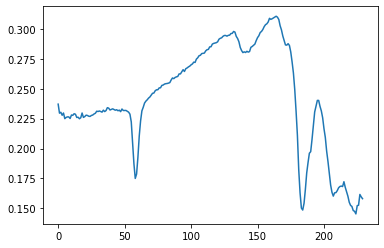

In [4]:
#after visual inspection, check the reflectance spectrum inside the pixel.
spectrum = data[100,100,:]
plt.plot(spectrum)
plt.show()

#please note that the wavelength hasn't assigned to the data, 0-230 bands represent the wavelength of 1043-2486
#the wavelength index will be assigned later

# Mineral Mapping using KMEANS
As the image shape is transformed into two dimension, we are losing the spatial correlation of each pixel. In this method, we ignore the influence of the surrounding pixel and cluster them using the reflectance spectrum similarity.

In [5]:
from sklearn.cluster import KMeans

In [6]:
pixels = data.reshape((57000, 230))
print (pixels.shape)

(57000, 230)


In [7]:
imagedf=pd.DataFrame(pixels)

In [8]:
def optimise_k_means(data, max_k):
    means = []
    inertias = []
    
    for k in range(1,max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        means.append(k)
        inertias.append(kmeans.inertia_)
    return means, inertias    

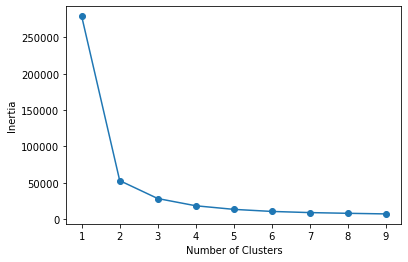

In [9]:
means, inertias= optimise_k_means(imagedf, 10)

plt.plot(means, inertias, 'o-')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

According to the K-Means inertia, clustering the data into 5 classes (based on the reference information) is acceptable. In this case we add one more class, as the background of the image is also classified.

In [41]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(imagedf)
imagedf['minerals'] = kmeans.labels_

In [42]:
imagenpy=imagedf.to_numpy()
print (imagenpy.shape)

(57000, 231)


In [43]:
classified=imagenpy.reshape(285, 200, 231)

In [44]:
MinMapKmeans=classified[:, :, 230]

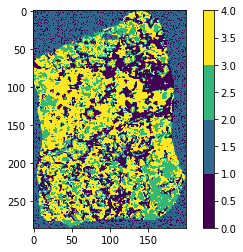

In [45]:
plt.imshow(MinMapKmeans, cmap=plt.cm.get_cmap('viridis',4))
plt.colorbar()

### Mineral Naming
According to the reference, the mineral occured in this rock are: Tourmaline, Muscovite and Illite (Normal and High Crystalline).
Spectral library from John Hopkins University was used to define the mineralogy. However, the different spectral resolution is ignored in this case. Visual comparison on the absorption features is the deciding factor in the classes naming process. 

In [46]:
#Helper Functions
def loadJHU(JHU):
    Mineral=pd.read_excel(JHU, header = 0)
    Mineral=Mineral[(Mineral.Wavelength >= 1.043) & (Mineral.Wavelength <= 2.486)]
    Mineral.set_index('Wavelength', drop=True, inplace=True)
    return Mineral

def wavelengthAssignment(minWave, maxWave, totalBand):
    step=(maxWave-minWave)/totalBand
    wavelength=[]
    i=minWave
    while i < maxWave :
        i=round(i+step, 1)
        wavelength.append(i)
    wavelength=[x for x in wavelength if x<maxWave]
    return wavelength

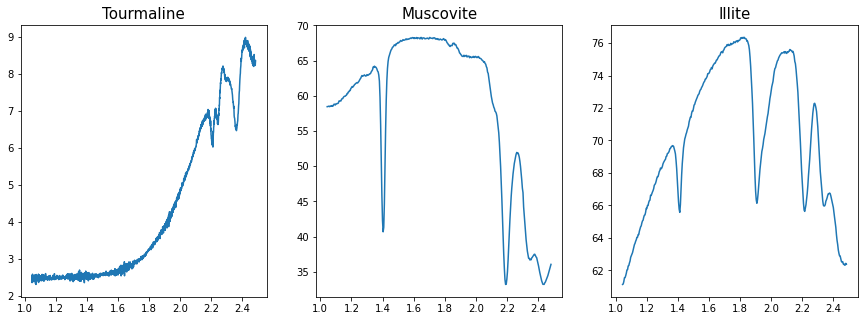

In [47]:
#load the spectral library
Tourmaline=loadJHU('tourmalineJHU.xlsx')
Muscovite=loadJHU('MuscoviteJHU.xlsx')
Illite=loadJHU('IlliteJHU.xlsx')
minerals=[Tourmaline, Muscovite, Illite]
mineralsName=["Tourmaline", "Muscovite", "Illite"]
fig,axes = plt.subplots(1,3,figsize=(15,5))
for i in range (-1,2, 1):
    axes[i].plot(minerals[i])
    axes[i].set_title(str(mineralsName[i]),fontsize=15)

By ignoring the spectral resolution and the reflectance value, the absorption features indicator for each minerals are summarized below:


Illite and muscovite has very similar absorption features, the ratio of water absorption features in 1900nm and AlOH at 2200 nm were used to distinguish the different (indicaty the crystalinity degree). Note that Muscovite clearly shown higher ratio of absorption feature in both wavelength range compared to Illite.

In [48]:
import plotly.express as px
fig = px.imshow(classified[:, :, 230], color_continuous_scale='viridis')
fig.show()

### Class 1 
NOTES: The result of KMeans indicate that the background image as class 1. As the class 0 is located inside the image, the class 0 selected as the representative of the class 1.

Text(0.5, 1.0, 'Class 1')

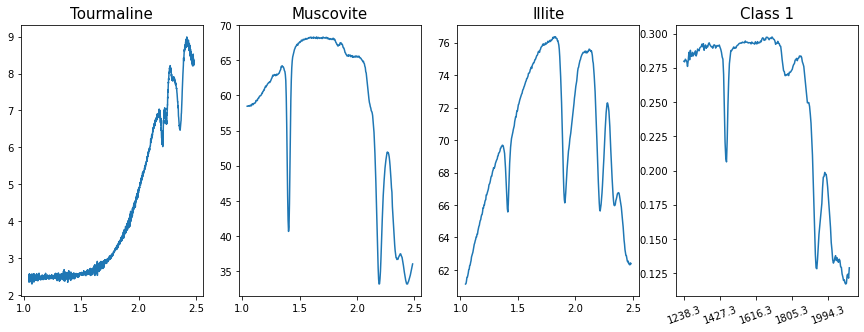

In [49]:
wave=wavelengthAssignment(1043, 2486, 230)
spectrum1 = data[94,162,:] #the y, x, and the data
xlabel=[]
for x in range (0,230, 30):
    xlabel.append(wave[x])

fig,axes = plt.subplots(1,4,figsize=(15,5))
for i in range (0,3, 1):
    axes[i].plot(minerals[i])
    axes[i].set_title(str(mineralsName[i]),fontsize=15)
    
axes[3].plot (spectrum1)
axes[3].set_xticklabels(xlabel, rotation=20)
axes[3].set_title('Class 1', fontsize=15)

### Class 2

Text(0.5, 1.0, 'Class 2')

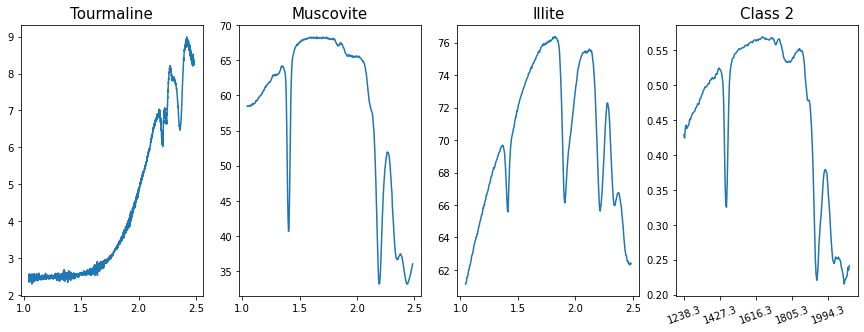

In [54]:
wave=wavelengthAssignment(1043, 2486, 230)
spectrum2 = data[119,24,:] #the y, x, and the data
xlabel=[]
for x in range (0,230, 30):
    xlabel.append(wave[x])

fig,axes = plt.subplots(1,4,figsize=(15,5))
for i in range (0,3, 1):
    axes[i].plot(minerals[i])
    axes[i].set_title(str(mineralsName[i]),fontsize=15)
    
axes[3].plot (spectrum2)
axes[3].set_xticklabels(xlabel, rotation=20)
axes[3].set_title('Class 2', fontsize=15)

### Class 3

Text(0.5, 1.0, 'Class 3')

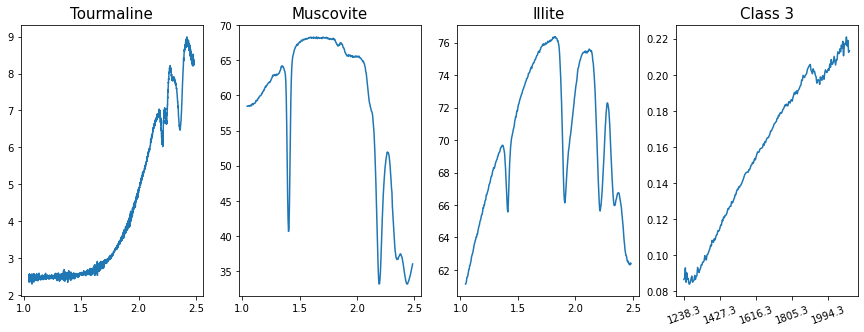

In [51]:
wave=wavelengthAssignment(1043, 2486, 230)
spectrum3 = data[177,62,:] #the y, x, and the data
xlabel=[]
for x in range (0,230, 30):
    xlabel.append(wave[x])

fig,axes = plt.subplots(1,4,figsize=(15,5))
for i in range (0,3, 1):
    axes[i].plot(minerals[i])
    axes[i].set_title(str(mineralsName[i]),fontsize=15)
    
axes[3].plot (spectrum3)
axes[3].set_xticklabels(xlabel, rotation=20)
axes[3].set_title('Class 3', fontsize=15)

### Class 4

Text(0.5, 1.0, 'Class 4')

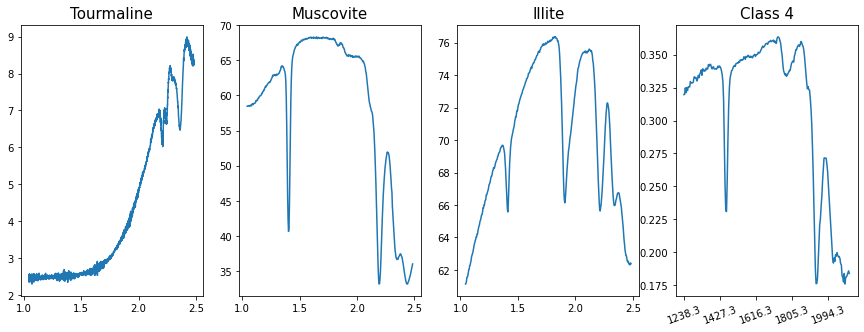

In [52]:
wave=wavelengthAssignment(1043, 2486, 230)
spectrum4 = data[115,120,:] #the y, x, and the data
xlabel=[]
for x in range (0,230, 30):
    xlabel.append(wave[x])

fig,axes = plt.subplots(1,4,figsize=(15,5))
for i in range (0,3, 1):
    axes[i].plot(minerals[i])
    axes[i].set_title(str(mineralsName[i]),fontsize=15)
    
axes[3].plot (spectrum4)
axes[3].set_xticklabels(xlabel, rotation=20)
axes[3].set_title('Class 4', fontsize=15)

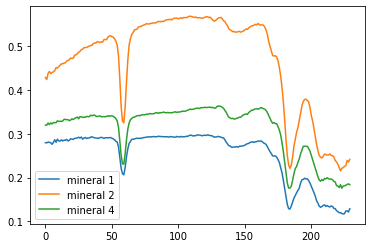

In [55]:
#plot the 3 similar minerals to distinguish between the muscovite and illite
plt.plot(spectrum1, label="mineral 1")
plt.plot(spectrum2, label="mineral 2")
plt.plot(spectrum4, label="mineral 4")
plt.legend()
plt.show()

## Mineral Map
To conclude:
Mineral 1 is representing Illite HX (high crystalinity)
Mineral 2 is representing Muscovite
Mineral 3 is representing Tourmaline
Mineral 4 is representing Illite (Low cristalinity)

In [63]:
Mineralogy= {1: "Illite HX",
            2: "Muscovite",
            3: "Tourmaline",
            4: "Illite"}

imagedf['mineralogy']=imagedf['minerals'].map(Mineralogy) #assign the mineralogy into the dataframe

,0,1,2,3,4,5,6,7,8,9,...,222,223,224,225,226,227,228,229,minerals,mineralogy
56995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Illite HX
56996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Illite HX
56997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Illite HX
56998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Illite HX
56999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Illite HX


In [66]:
#create pickle
imagedf.to_pickle("./MinMapKmeans.pkl")

# Mineral Mapping using PCA

(0.0, 10.0)

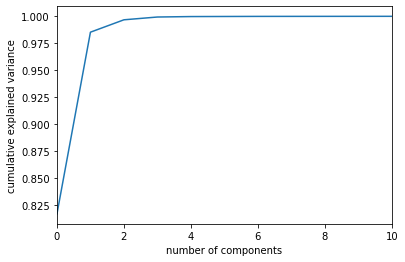

In [33]:
from sklearn.decomposition import PCA
pca = PCA().fit(imagedf)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.xlim([0,10])

In [40]:
pca = PCA(n_components=2)
test=pca.fit_transform(imagedf)

In [41]:
print (test.shape)
PCAclass=test.reshape(285, 200, 2)

(57000, 4)


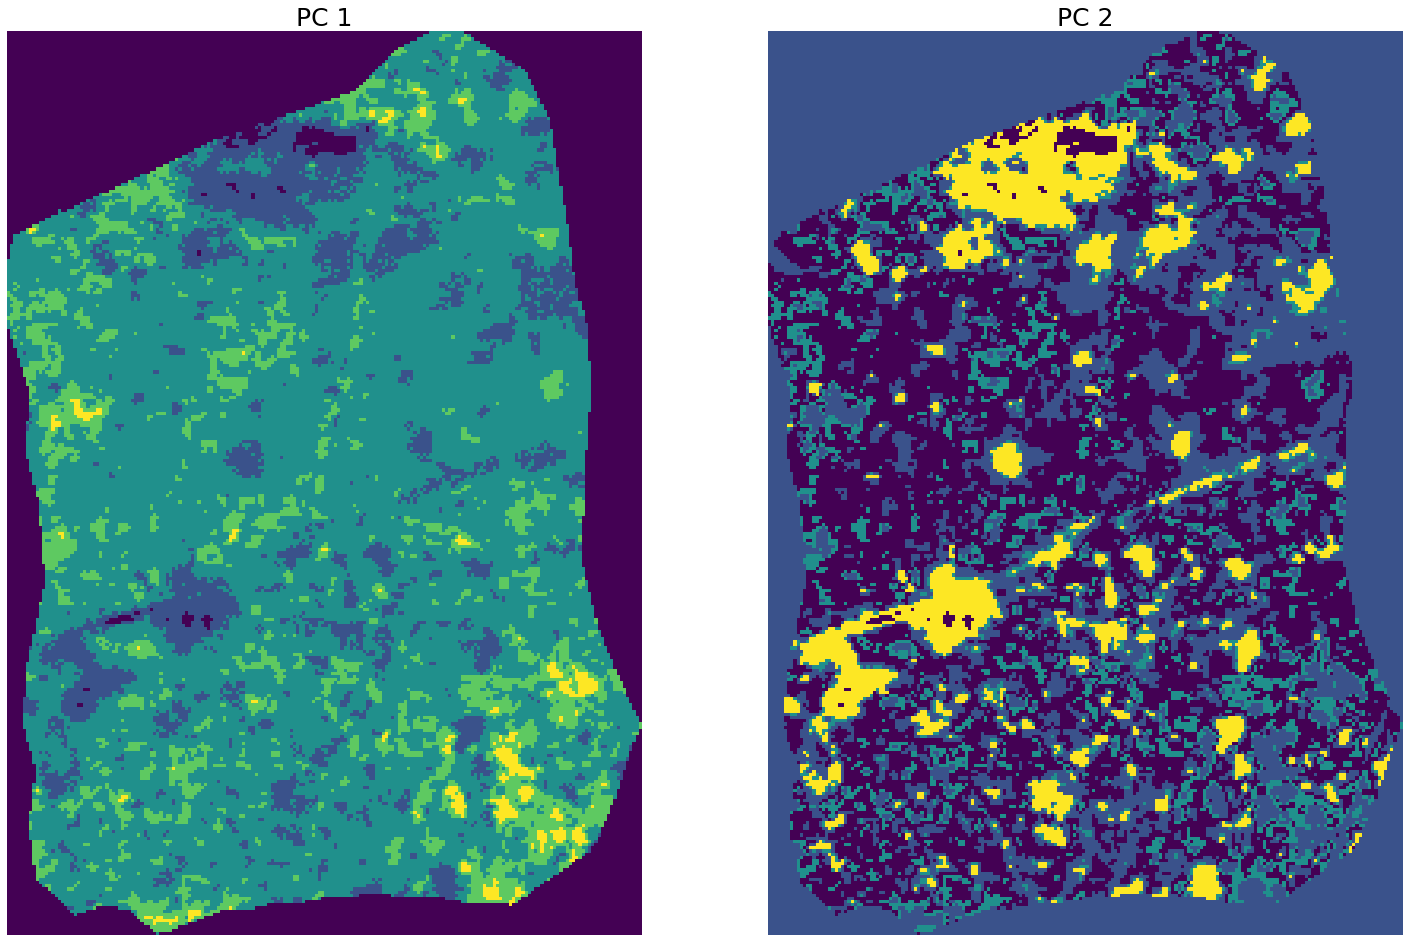

In [154]:
fig,axes = plt.subplots(1,2,figsize=(25,20),sharex='all',
                        sharey='all')

for i in range (2):
    axes[i].imshow(PCAclass[:, :, i],cmap=plt.cm.get_cmap('viridis', 5))
    axes[i].set_title('PC '+str(i+1),fontsize=25)
    axes[i].axis('off')


### With the PCA, we can distinguish the variation in the image, and we can repeat the comparison with JHU library to d